In [ ]:
%pylab inline
from google.colab import drive

drive.mount('/content/gdrive')
%cd 'gdrive/My Drive/Colab Notebooks/cv-assign'

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/cv-assign


In [ ]:
from fastai.vision import *
from pathlib import Path
import pandas as pd
import numpy as np
import json

In [ ]:
!ls

bbc_train  data_sample	graphics  notebooks  requirements.txt  util
challenge  dev		__MACOSX  README.md  sample_models


In [ ]:
%cd deep_learning_for_computer_vision/

/content/gdrive/My Drive/Colab Notebooks/cv-assign/deep_learning_for_computer_vision


In [ ]:
!ls bbc_train/

bboxes.json  classification_labels.csv	images	masks  models


In [ ]:
path=Path('bbc_train')

In [ ]:
path.ls()

[PosixPath('bbc_train/.DS_Store'),
 PosixPath('bbc_train/images'),
 PosixPath('bbc_train/classification_labels.csv'),
 PosixPath('bbc_train/bboxes.json'),
 PosixPath('bbc_train/masks'),
 PosixPath('bbc_train/models')]

In [ ]:
labels=pd.read_csv(path/'classification_labels.csv')
labels.head()

,filename,label,label_index
0,P2050936.jpg,ball,2
1,P2050922.jpg,ball,2
2,P2060163.jpg,brick,1
3,P2060003.jpg,ball,2
4,P2060017.jpg,ball,2


In [ ]:
def get_y_fn(x): return path/'masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

src = (SegmentationItemList.from_folder(path/'images')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))


In [ ]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True), 
        nn.BatchNorm2d(nf))

In [ ]:
custom_head=nn.Sequential(conv_trans(512, 256), 
                          conv_trans(256, 128),
                          conv_trans(128, 64),
                          conv_trans(64, 32), 
                          nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))

In [ ]:


def pixel_accuracy(yhat, y):
    y_=y.squeeze(dim=1)
    yhat_=yhat.argmax(dim=1)
    return (y_==yhat_).sum().float()/y.numel()



In [ ]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head, metrics=pixel_accuracy)

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


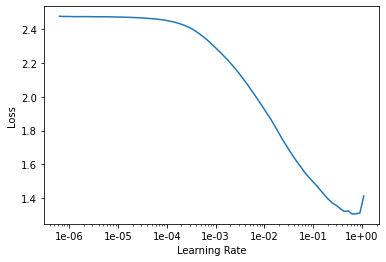

In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-3
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,1.694695,1.501168,0.664044,00:20
1,0.884948,0.343286,0.946147,00:20
2,0.498382,0.231266,0.956287,00:20
3,0.328818,0.236472,0.956777,00:20


In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


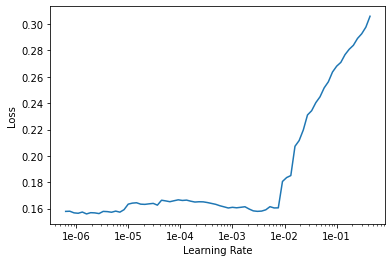

In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.163652,0.157001,0.965429,00:20
1,0.152094,0.131775,0.970086,00:20
2,0.130581,0.104277,0.976091,00:20
3,0.109885,0.084639,0.979696,00:20
4,0.093561,0.077089,0.981843,00:20
5,0.082129,0.068082,0.983354,00:20
6,0.075811,0.066491,0.983679,00:20
7,0.071992,0.064963,0.983794,00:20


In [ ]:
#learn.load('my-weights')

In [ ]:
learn.save('my-weights')

In [ ]:
!ls

bbc_train  data_sample	graphics  notebooks  requirements.txt  util
challenge  dev		__MACOSX  README.md  sample_models


In [ ]:
learn.export('../../sample_models/export.pkl')